## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import box
from rasterio.mask import mask
from scipy.spatial import cKDTree
# k-dimensional tree (KDTree) data structure, optimized for efficient nearest-neighbor searches 
# in multi-dimensional space.

In [2]:
solar_file = "data/solar/ottawa_nsrdb_2020.csv"
landcover_file = "data/land/landcover-2020-classification.tif"
dem_file = "data/land/output_be.tif"
dem_slope_file = "data/land/viz/viz.be_slope.tif"
dem_aspect_file = "data/land/viz/viz.be_aspect.tif"
# No protected areas in Ottawa.
grid_lines_file = "data/Ottawa_grid_lines/ottawa_grid_lines.shp"
grid_substations_file = "data/Ottawa_grid_substations/ottawa_substations.shp"

## Slope
There is a .tif file for the slope values in Ottawa region. 

## Land Cover
The suitable lands are chosen. 

In [3]:
bbox = box(-76.5, 44.9, -75.0, 45.6) # min of lon & lat, max of lon & lat
geo = gpd.GeoDataFrame({"geometry":[bbox]}, crs="EPSG:4326")
with rasterio.open(landcover_file) as src:
    lc = src.read(1, out_shape=(src.height // 20, src.width // 20))
    profile = src.profile
    out_img, out_transform = mask(src, geo.geometry, crop=True)
classes = np.unique(lc)

In [4]:
print(classes)

[ 0  1  2  5  6  8 10 11 12 13 14 15 16 17 18 19]


Natural Resources Canada land cover legends https://www150.statcan.gc.ca/n1/pub/16-510-x/16-510-x2025003-eng.htm
Cropland: 2, Sparsely vegetated land: 9, Barren land: 10

In [5]:
suitable_classes = [2, 9, 10]
lc_mask = np.isin(lc, suitable_classes).astype(np.uint8)


In [6]:
profile.update(dtype=rasterio.uint8)

out_fp = "data/processed/ottawa_landcover_mask.tif"
os.makedirs(os.path.dirname(out_fp), exist_ok=True)

with rasterio.open(out_fp, "w", **profile) as dst:
    dst.write(lc_mask, 1)

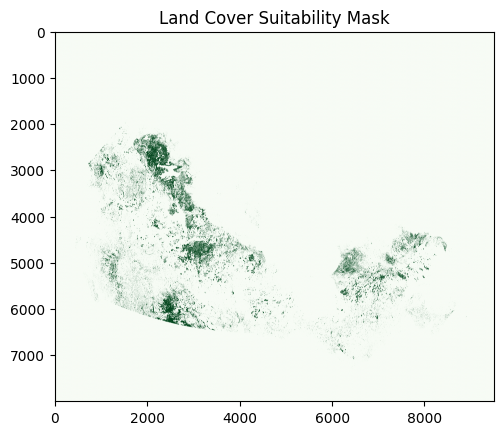

In [7]:
plt.imshow(lc_mask, cmap="Greens")
plt.title("Land Cover Suitability Mask")
plt.show()

## No procted areas

## Grid Proximity

DEM CRS: EPSG:3979
Grid CRS (before): EPSG:4326
Grid CRS (after): PROJCS["NAD83(CSRS) / Canada Atlas Lambert",GEOGCS["NAD83(CSRS)",DATUM["NAD83_Canadian_Spatial_Reference_System",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6140"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4617"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-95],PARAMETER["standard_parallel_1",49],PARAMETER["standard_parallel_2",77],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3979"]]
Unique values in line_raster: [0 1]


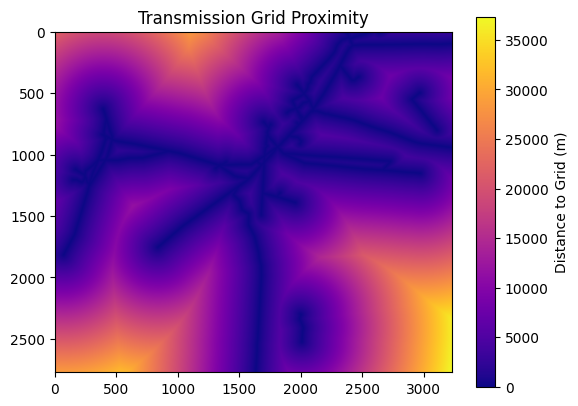

In [8]:
import geopandas as gpd
import rasterio
from rasterio import features
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import os

# ======================
# Grid Proximity (distance raster)
# ======================

# Read transmission grid
grid_lines = gpd.read_file(grid_lines_file)

with rasterio.open(dem_file) as src:
    dem_crs = src.crs
    transform = src.transform
    width, height = src.width, src.height
    out_meta = src.meta.copy()

print("DEM CRS:", dem_crs)
print("Grid CRS (before):", grid_lines.crs)

# Reproject grid to DEM CRS
grid_lines = grid_lines.to_crs(dem_crs)

print("Grid CRS (after):", grid_lines.crs)

# Rasterize grid lines
line_raster = features.rasterize(
    [(geom, 1) for geom in grid_lines.geometry if geom is not None],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype=np.uint8
)

print("Unique values in line_raster:", np.unique(line_raster))

# Distance transform
distance_pixels = distance_transform_edt(1 - line_raster)

pixel_size = abs(transform.a)
distance_raster = distance_pixels * pixel_size

# Save
out_fp = "data/processed/ottawa_grid_distance.tif"
os.makedirs(os.path.dirname(out_fp), exist_ok=True)

out_meta.update(dtype=rasterio.float32, count=1)

with rasterio.open(out_fp, "w", **out_meta) as dst:
    dst.write(distance_raster.astype(np.float32), 1)

# Plot
plt.imshow(distance_raster, cmap="plasma")
plt.colorbar(label="Distance to Grid (m)")
plt.title("Transmission Grid Proximity")
plt.show()

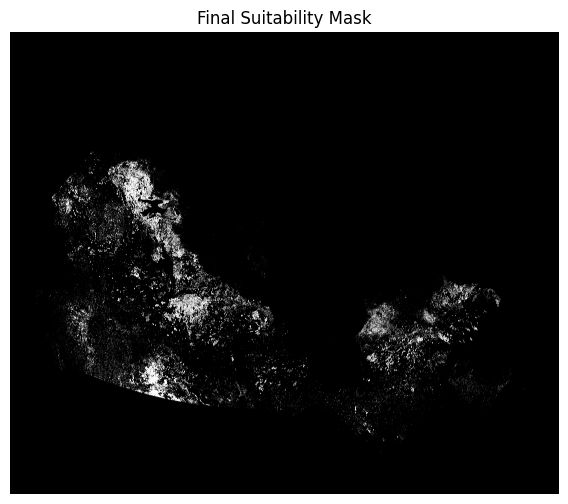

Final suitability mask saved to: data/processed/ottawa_final_suitability.tif


In [9]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt
import os

# File paths
slope_file = "data/land/viz/viz.be_slope.tif"
landcover_mask_file = "data/processed/ottawa_landcover_mask.tif"
out_file = "data/processed/ottawa_final_suitability.tif"

# Target downsample factor (e.g., 10 → 10x smaller)
factor = 10

# ======================
# 1. Load land cover mask and downsample
# ======================
with rasterio.open(landcover_mask_file) as src:
    lc_mask = src.read(
        1,
        out_shape=(src.height // factor, src.width // factor),
        resampling=Resampling.nearest
    ).astype(bool)
    lc_profile = src.profile
    lc_profile.update(
        height=lc_mask.shape[0],
        width=lc_mask.shape[1],
        transform=src.transform * src.transform.scale(
            (src.width / lc_mask.shape[1]),
            (src.height / lc_mask.shape[0])
        )
    )

# ======================
# 2. Load slope raster and downsample to land cover shape
# ======================
with rasterio.open(slope_file) as src:
    slope = src.read(
        1,
        out_shape=lc_mask.shape,
        resampling=Resampling.bilinear
    )
slope_mask = slope < 5

# ======================
# 3. Combine masks
# ======================
final_mask = slope_mask & lc_mask

# ======================
# 4. Plot
# ======================
plt.figure(figsize=(8,6))
plt.imshow(final_mask, cmap="gray")
plt.title("Final Suitability Mask")
plt.axis("off")
plt.show()

# ======================
# 5. Save final mask
# ======================
os.makedirs(os.path.dirname(out_file), exist_ok=True)
lc_profile.update(dtype=rasterio.uint8, count=1)
with rasterio.open(out_file, "w", **lc_profile) as dst:
    dst.write(final_mask.astype(np.uint8), 1)

print(f"Final suitability mask saved to: {out_file}")